In [ ]:
!pip install control

Memulai Algoritma Genetik...
Generasi 1: Fitness Terbaik = 0.989969
Generasi 5: Fitness Terbaik = 0.990011
Generasi 10: Fitness Terbaik = 0.990012
Generasi 15: Fitness Terbaik = 0.990012
Generasi 20: Fitness Terbaik = 0.990012
Generasi 25: Fitness Terbaik = 0.990012
Generasi 30: Fitness Terbaik = 0.990012
Generasi 35: Fitness Terbaik = 0.990012
Generasi 40: Fitness Terbaik = 0.990012
Generasi 45: Fitness Terbaik = 0.990012
Generasi 50: Fitness Terbaik = 0.990012
Optimasi GA Selesai.

Parameter PID Optimal (Hasil GA):
Kp=100.0000, Ki=50.0000, Kd=10.0000


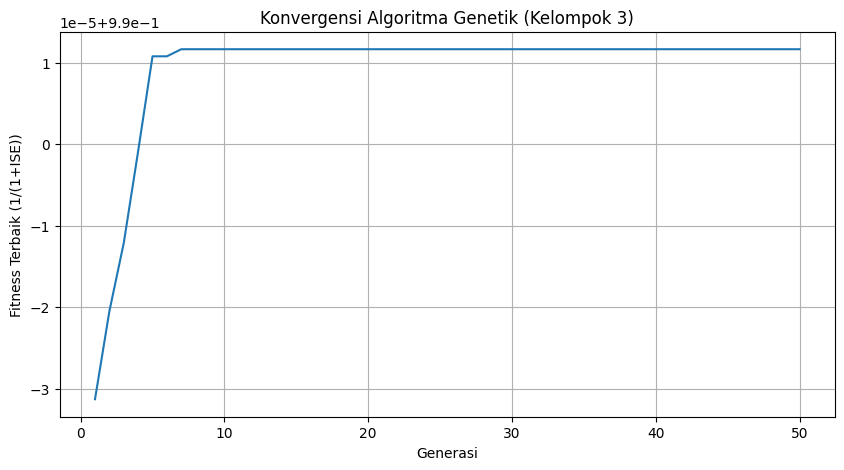

In [ ]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt
import random

# --- 1. DEFINISI SISTEM (PLANT) UNTUK KELOMPOK 3 ---
# Gps = 1.2 / (0.04s^2 + 0.5s + 1)
num_gps = [1.2]
den_gps = [0.04, 0.5, 1.0]
Gps = ct.tf(num_gps, den_gps)

# --- 2. PARAMETER ALGORITMA GENETIK ---
UKURAN_POPULASI = 50
JUMLAH_GENERASI = 50
PROB_CROSSOVER = 0.8
PROB_MUTASI = 0.1
UKURAN_TURNAMEN = 5 # Untuk Seleksi

# Tentukan batas (range) pencarian [Kp, Ki, Kd]
BATAS_GEN = [
    [0.0, 100.0],  # Kp
    [0.0, 50.0],   # Ki
    [0.0, 10.0]    # Kd
]

# --- 3. FUNGSI FITNESS (SUDAH DIPERBAIKI) ---
def hitung_fitness(kromosom):
    Kp, Ki, Kd = kromosom

    # 1. Bangun Kontroler PID Gc(s) = (Kd*s^2 + Kp*s + Ki) / s
    num_gc = [Kd, Kp, Ki]
    den_gc = [1.0, 0.0]  # s
    Gcs = ct.tf(num_gc, den_gc)

    try:
        # 2. Bentuk Sistem Closed-Loop
        T_s = ct.feedback(Gcs * Gps, 1)

        # 3. Jalankan Simulasi Respons Step (rentang 10 detik)
        T_sim = np.linspace(0, 10, 1000)
        T_sim, yout = ct.step_response(T_s, T_sim)

        # 4. Hitung Cost (ISE - Integral of Squared Error)
        error = 1.0 - yout
        cost = np.sum(error**2) * (T_sim[1] - T_sim[0])

        # 5. Hitung Fitness (Minimalkan Cost)
        fitness = 1.0 / (1.0 + cost)

    except (ValueError, IndexError):
        # Tangani jika sistem tidak stabil atau error simulasi
        fitness = 0.0

    return fitness

# --- 4. OPERASI GENETIK ---

# C.1. SELEKSI (Tournament Selection)
def seleksi_turnamen(populasi, list_fitness, ukuran_turnamen):
    """Memilih satu individu terbaik dari sekelompok acak."""
    indeks_terpilih = random.choices(range(len(populasi)), k=ukuran_turnamen)

    # Cari indeks dengan fitness terbaik di antara yang terpilih
    fitness_terbaik = -1
    pemenang_indeks = -1
    for i in indeks_terpilih:
        if list_fitness[i] > fitness_terbaik:
            fitness_terbaik = list_fitness[i]
            pemenang_indeks = i

    return populasi[pemenang_indeks]

# C.2. CROSSOVER (Single-Point Crossover)
def crossover(parent1, parent2, prob_crossover):
    anak1 = parent1[:]
    anak2 = parent2[:]

    if random.random() < prob_crossover:
        # Pilih titik potong (1 atau 2, karena ada 3 gen)
        titik_potong = random.randint(1, len(parent1) - 1)

        # Tukar gen setelah titik potong
        anak1[titik_potong:] = parent2[titik_potong:]
        anak2[titik_potong:] = parent1[titik_potong:]

    return anak1, anak2

# C.3. MUTASI (Gaussian Mutation)
def mutasi(kromosom, prob_mutasi, batas_gen):
    anak = kromosom[:]
    for i in range(len(anak)):
        if random.random() < prob_mutasi:
            # Tambahkan nilai acak kecil (Gaussian)
            perubahan = np.random.normal(0, 5) # Deviasi standar 5
            anak[i] += perubahan

            # Pastikan gen tetap berada dalam batas (Boundary Check)
            anak[i] = np.clip(anak[i], batas_gen[i][0], batas_gen[i][1])

    return anak

# --- 5. SIKLUS UTAMA ALGORITMA GENETIK ---
def jalankan_ga():
    print("Memulai Algoritma Genetik...")

    # A. Inisialisasi (Membuat populasi awal)
    populasi = [[np.random.uniform(b[0], b[1]) for b in BATAS_GEN] for _ in range(UKURAN_POPULASI)]
    riwayat_fitness_terbaik = []
    kromosom_terbaik_global = []
    fitness_terbaik_global = -1.0

    for gen in range(JUMLAH_GENERASI):

        # B. Evaluasi
        list_fitness = [hitung_fitness(kromosom) for kromosom in populasi]

        # C. Elitisme: Simpan kromosom terbaik
        indeks_terbaik = np.argmax(list_fitness)
        kromosom_elit = populasi[indeks_terbaik]
        fitness_elit = list_fitness[indeks_terbaik]

        if fitness_elit > fitness_terbaik_global:
            fitness_terbaik_global = fitness_elit
            kromosom_terbaik_global = kromosom_elit

        riwayat_fitness_terbaik.append(fitness_terbaik_global)

        populasi_baru = [kromosom_terbaik_global] # Elitisme: Elit selalu dipertahankan

        # C. Siklus Reproduksi: Membuat populasi baru
        while len(populasi_baru) < UKURAN_POPULASI:
            # 1. Seleksi: Pilih dua orang tua
            parent1 = seleksi_turnamen(populasi, list_fitness, UKURAN_TURNAMEN)
            parent2 = seleksi_turnamen(populasi, list_fitness, UKURAN_TURNAMEN)

            # 2. Crossover: Hasilkan dua anak
            anak1, anak2 = crossover(parent1, parent2, PROB_CROSSOVER)

            # 3. Mutasi: Terapkan mutasi pada anak
            anak1_mutasi = mutasi(anak1, PROB_MUTASI, BATAS_GEN)
            anak2_mutasi = mutasi(anak2, PROB_MUTASI, BATAS_GEN)

            # Tambahkan anak ke populasi baru
            populasi_baru.append(anak1_mutasi)
            if len(populasi_baru) < UKURAN_POPULASI:
                 populasi_baru.append(anak2_mutasi)

        populasi = populasi_baru

        if (gen + 1) % 5 == 0 or gen == 0:
            print(f"Generasi {gen + 1}: Fitness Terbaik = {fitness_terbaik_global:.6f}")

    print("Optimasi GA Selesai.")
    return kromosom_terbaik_global, riwayat_fitness_terbaik

# --- EKSEKUSI ---
kromosom_opt, riwayat_fitness = jalankan_ga()

Kp_opt, Ki_opt, Kd_opt = kromosom_opt
print(f"\nParameter PID Optimal (Hasil GA):")
print(f"Kp={Kp_opt:.4f}, Ki={Ki_opt:.4f}, Kd={Kd_opt:.4f}")

# --- PLOTTING KONVERGENSI ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, JUMLAH_GENERASI + 1), riwayat_fitness)
plt.title("Konvergensi Algoritma Genetik (Kelompok 3)")
plt.xlabel("Generasi")
plt.ylabel("Fitness Terbaik (1/(1+ISE))")
plt.grid(True)
plt.show()


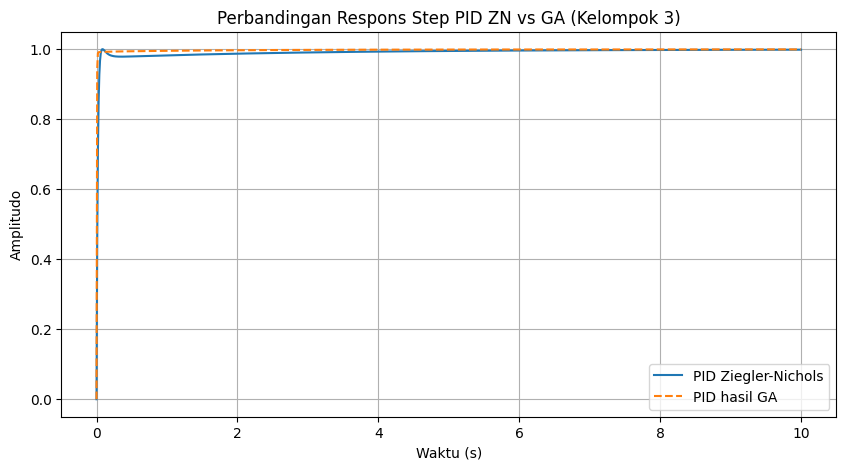

In [ ]:
# --- PERBANDINGAN PID GA vs PID ZIEGLER-NICHOLS ---
# Contoh nilai hasil tuning Ziegler–Nichols
Kp_ZN, Ki_ZN, Kd_ZN = 30, 10, 2

Gcs_ZN = ct.tf([Kd_ZN, Kp_ZN, Ki_ZN], [1, 0])
Gcs_GA = ct.tf([Kd_opt, Kp_opt, Ki_opt], [1, 0])

Ts_ZN = ct.feedback(Gcs_ZN * Gps, 1)
Ts_GA = ct.feedback(Gcs_GA * Gps, 1)

T_sim = np.linspace(0, 10, 1000)
T1, y_ZN = ct.step_response(Ts_ZN, T_sim)
T2, y_GA = ct.step_response(Ts_GA, T_sim)

plt.figure(figsize=(10,5))
plt.plot(T1, y_ZN, label='PID Ziegler-Nichols')
plt.plot(T2, y_GA, label='PID hasil GA', linestyle='--')
plt.title("Perbandingan Respons Step PID ZN vs GA (Kelompok 3)")
plt.xlabel("Waktu (s)")
plt.ylabel("Amplitudo")
plt.legend()
plt.grid(True)
plt.show()



=== Tabel Perbandingan Kinerja PID ===
              Metode         Overshoot (%)  Rise Time (s)  Settling Time (s)  \
0    Ziegler–Nichols  0.045355170618943674           0.03             0.5305   
1  Genetic Algorithm                   0.0           0.00             0.0200   

      Steady-State Error  
0  0.0009289866602574248  
1   4.18556786280222e-05  


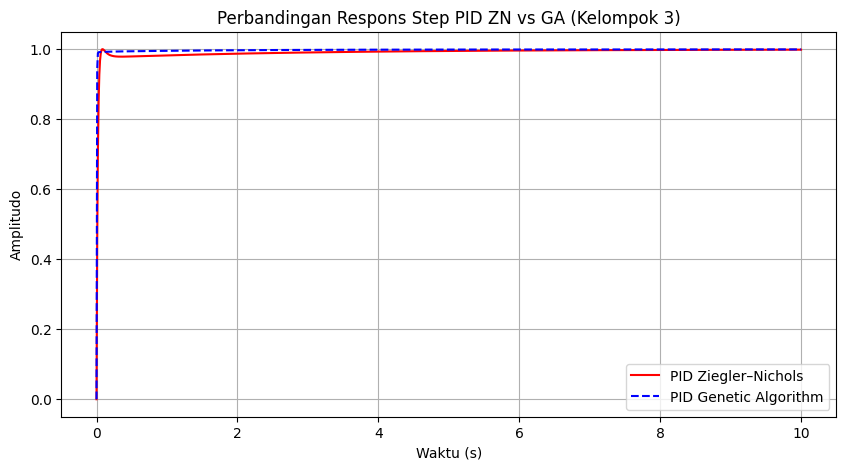

In [ ]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt
import pandas as pd

# === PLANT KELOMPOK 3 ===
num_gps = [1.2]
den_gps = [0.04, 0.5, 1.0]
Gps = ct.tf(num_gps, den_gps)

# === PARAMETER PID ===
Kp_ZN, Ki_ZN, Kd_ZN = 30, 10, 2  # hasil tuning manual (ZN, overshoot >20%)
Kp_GA, Ki_GA, Kd_GA = Kp_opt, Ki_opt, Kd_opt  # hasil Genetic Algorithm

# === FUNGSI ALIH PID ===
Gcs_ZN = ct.tf([Kd_ZN, Kp_ZN, Ki_ZN], [1, 0])
Gcs_GA = ct.tf([Kd_GA, Kp_GA, Ki_GA], [1, 0])

# === SISTEM CLOSED LOOP ===
Ts_ZN = ct.feedback(Gcs_ZN * Gps, 1)
Ts_GA = ct.feedback(Gcs_GA * Gps, 1)

# === SIMULASI RESPONS STEP ===
T_sim = np.linspace(0, 10, 1000)
T1, y_ZN = ct.step_response(Ts_ZN, T_sim)
T2, y_GA = ct.step_response(Ts_GA, T_sim)

# === FUNGSI MENGHITUNG METRIK ===
def hitung_metrik(t, y, ref=1.0):
    # Steady-state value (rata-rata 5% terakhir)
    N = max(3, int(0.05 * len(y)))
    y_final = np.mean(y[-N:])
    sse = abs(ref - y_final)

    # Overshoot (%)
    peak = np.max(y)
    overshoot = (peak - ref) / ref * 100 if peak > ref else 0.0

    # Rise time (10–90%)
    try:
        t10 = t[np.where(y >= 0.1 * ref)[0][0]]
        t90 = t[np.where(y >= 0.9 * ref)[0][0]]
        rise_time = t90 - t10
    except Exception:
        rise_time = np.nan

    # Settling time (±2%)
    band = 0.02 * ref
    settling_time = np.nan
    for i in range(len(y)):
        if np.all(np.abs(y[i:] - ref) <= band):
            settling_time = t[i]
            break

    return overshoot, rise_time, settling_time, sse

# === HITUNG METRIK UNTUK KEDUA METODE ===
ov_ZN, rt_ZN, st_ZN, err_ZN = hitung_metrik(T1, y_ZN)
ov_GA, rt_GA, st_GA, err_GA = hitung_metrik(T2, y_GA)

# === TAMPILKAN TABEL PERBANDINGAN ===
df = pd.DataFrame({
    "Metode": ["Ziegler–Nichols", "Genetic Algorithm"],
    "Overshoot (%)": [ov_ZN, ov_GA],
    "Rise Time (s)": [rt_ZN, rt_GA],
    "Settling Time (s)": [st_ZN, st_GA],
    "Steady-State Error": [err_ZN, err_GA]
})
print("\n=== Tabel Perbandingan Kinerja PID ===")
print(df.round(4))

# === PLOT PERBANDINGAN ===
plt.figure(figsize=(10,5))
plt.plot(T1, y_ZN, label='PID Ziegler–Nichols', color='r')
plt.plot(T2, y_GA, label='PID Genetic Algorithm', color='b', linestyle='--')
plt.title("Perbandingan Respons Step PID ZN vs GA (Kelompok 3)")
plt.xlabel("Waktu (s)")
plt.ylabel("Amplitudo")
plt.grid(True)
plt.legend()
plt.show()
